In [6]:
import os
import shutil
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import yaml
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.signal import savgol_filter, medfilt
import starbars

from towbintools.foundation import file_handling
from towbintools.foundation.utils import interpolate_nans
from towbintools.data_analysis import (
    compute_larval_stage_duration,
    compute_series_at_time_classified,
    filter_series_with_classification,
    rescale_and_aggregate,
    rescale_series,
)
from plotting_functions import (
    combine_experiments,
    plot_aggregated_series,
    plot_correlation,
    plot_correlation_at_ecdysis,
    boxplot_at_molt,
    boxplot_larval_stage,
    plot_growth_curves_individuals,
    plot_deviation_from_model_at_ecdysis,
    plot_normalized_proportions,
    plot_deviation_from_model,
    get_most_average_proportions_at_ecdysis,
    get_most_average_size_at_ecdysis,
    overlay_contours,
    plot_developmental_success,
    plot_arrests,
    plot_heterogeneity_at_ecdysis,
    plot_heterogeneity_rescaled_data,
    build_legend,
    combine_series,
    transform_series,
    compute_growth_rate,
    rescale,
)

# Configure warnings
warnings.filterwarnings("once")

In [7]:
filemap_paths = [
    "/mnt/towbin.data/shared/igheor/20250208_Ti2_10x_suppressor_screen_daf16_160_186_344_338_25C_20250208_204911_158/analysis/report/analysis_filemap_annotated.csv",    
]

conditions_paths = [
    "/mnt/towbin.data/shared/igheor/20250208_Ti2_10x_suppressor_screen_daf16_160_186_344_338_25C_20250208_204911_158/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/igheor/20250208_Ti2_10x_suppressor_screen_daf16_160_186_344_338_25C_20250208_204911_158/plotting_backups/"

filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

# for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
#     output_name = f"analysis_filemap_{i}.csv"
#     output_name_config = f"config_{i}.yaml"
    
#     # Copy the filemap to the backup path
#     shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
#     shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# # Copy the current working directory to the backup path
# current_dir = os.getcwd()
# current_dir_name = os.path.basename(current_dir)
# destination = os.path.join(backup_path, current_dir_name)

# shutil.copytree(current_dir, destination, dirs_exist_ok=True)

# print("Backup completed successfully!")

In [8]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels, recompute_values_at_molt=False)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not contain infs or nans.
Caught an exception while interpolating series: Array must not co

In [9]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}, Number of individuals: {condition['ecdysis_time_step'].shape[0]}")

Condition: (0, {'raga-1:AID, EV'}), Number of individuals: 44
Condition: (1, {'raga-1:AID, col-10:TIR, EV'}), Number of individuals: 44
Condition: (2, {'raga-1:AID, vhp-1(sa366), EV'}), Number of individuals: 44
Condition: (3, {'raga-1:AID, col-10:TIR, vhp-1(sa366), EV'}), Number of individuals: 57
Condition: (4, {'raga-1:AID, daf-16 RNAi'}), Number of individuals: 53
Condition: (5, {'raga-1:AID, col-10:TIR, daf-16 RNAi'}), Number of individuals: 47
Condition: (6, {'raga-1:AID, vhp-1(sa366), daf-16 RNAi'}), Number of individuals: 43
Condition: (7, {'raga-1:AID, col-10:TIR, vhp-1(sa366), daf-16 RNAi'}), Number of individuals: 59


In [10]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

In [11]:
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'divide', 'body_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_length', 'divide', 'body_seg_str_aspect_ratio')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_max_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', 'subtract', 'body_seg_str_width_max_minus_mean_at_ecdysis')

conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 'divide', 'pharynx_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_length', 'divide', 'pharynx_seg_str_aspect_ratio')

conditions_struct = transform_series(conditions_struct, 'body_seg_str_width_mean', 'log', 'body_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_length', 'log', 'body_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_volume', 'log', 'body_seg_str_log_volume')

conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_width_mean', 'log', 'pharynx_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_length', 'log', 'pharynx_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_volume', 'log', 'pharynx_seg_str_log_volume')

In [12]:

# COMPUTE GROWTH RATES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_growth_rate')

conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_aspect_ratio', 'pharynx_seg_str_aspect_ratio_growth_rate')

# COMPUTE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_growth_rate')

conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_width_mean', 'pharynx_seg_str_log_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_length', 'pharynx_seg_str_log_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_volume', 'pharynx_seg_str_log_volume_growth_rate')

# RESCALE GROWTH RATES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume_growth_rate', 'body_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean_growth_rate', 'body_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length_growth_rate', 'body_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio_growth_rate', 'body_seg_str_aspect_ratio_growth_rate_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume_growth_rate', 'pharynx_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_width_mean_growth_rate', 'pharynx_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length_growth_rate', 'pharynx_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_aspect_ratio_growth_rate', 'pharynx_seg_str_aspect_ratio_growth_rate_rescaled')

# RESCALE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean_growth_rate', 'body_seg_str_log_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length_growth_rate', 'body_seg_str_log_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume_growth_rate', 'body_seg_str_log_volume_growth_rate_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_width_mean_growth_rate', 'pharynx_seg_str_log_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_length_growth_rate', 'pharynx_seg_str_log_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_volume_growth_rate', 'pharynx_seg_str_log_volume_growth_rate_rescaled')

# RESCALE SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_max', 'body_seg_str_width_max_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_aspect_ratio', 'pharynx_seg_str_aspect_ratio_rescaled')

# RESCALE SERIES FOR LOG TRANSFORMED SERIES

conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_rescaled')

# conditions_to_plot = [4]
# colors = None
# plot_aggregated_series(conditions_struct, ['body_seg_str_aspect_ratio_growth_rate'], conditions_to_plot, colors=colors, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = False, legend = {'description': ''})

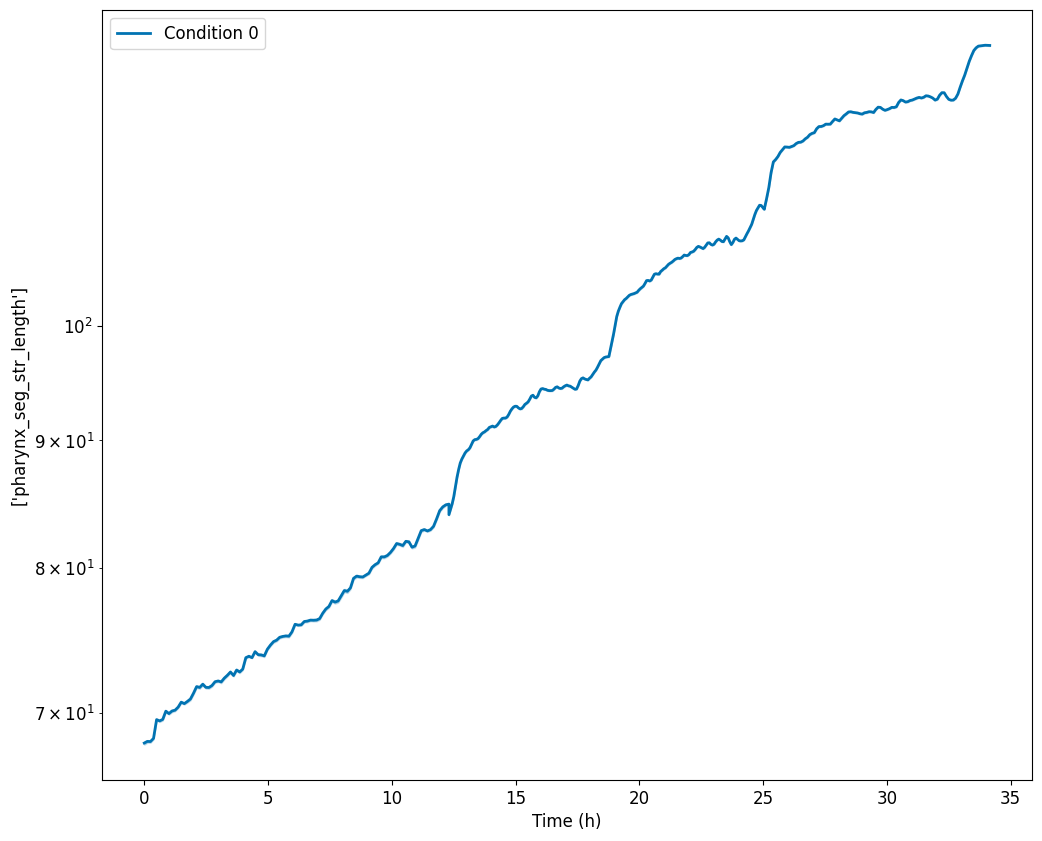

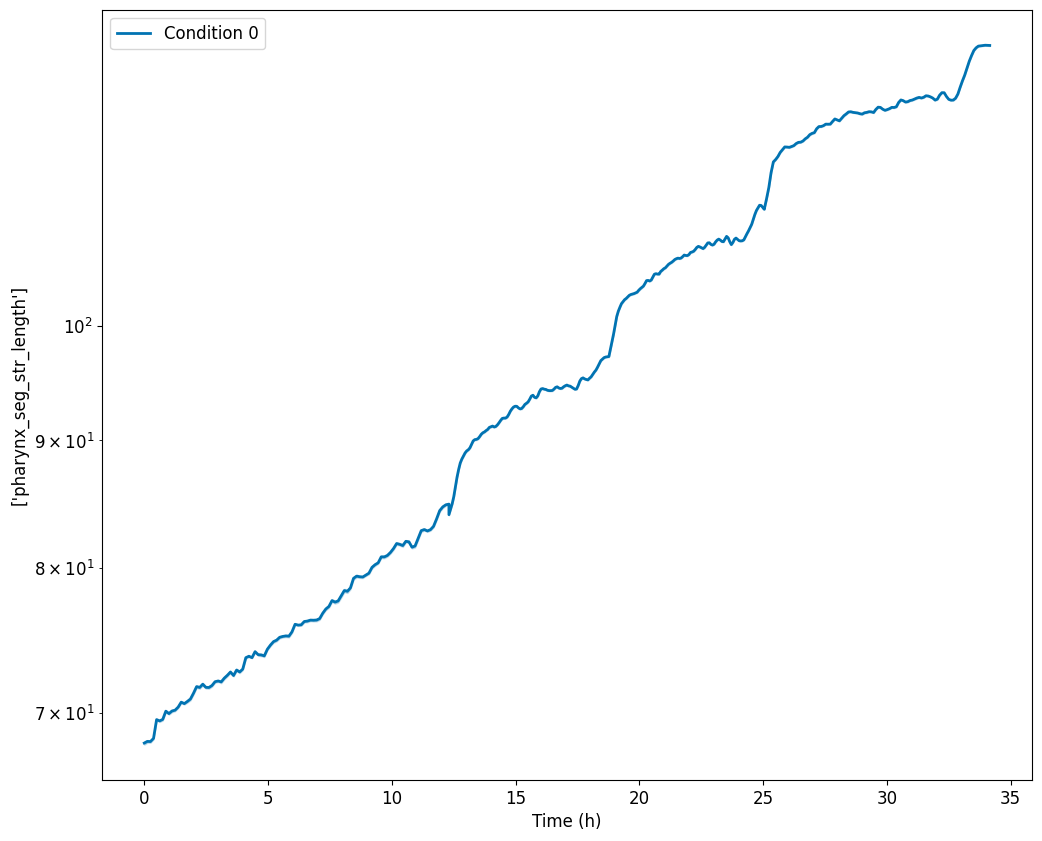

In [13]:
conditions_to_plot = [0]

plot_aggregated_series(conditions_struct, ['pharynx_seg_str_length'], conditions_to_plot, colors=None, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = True, legend = None)

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


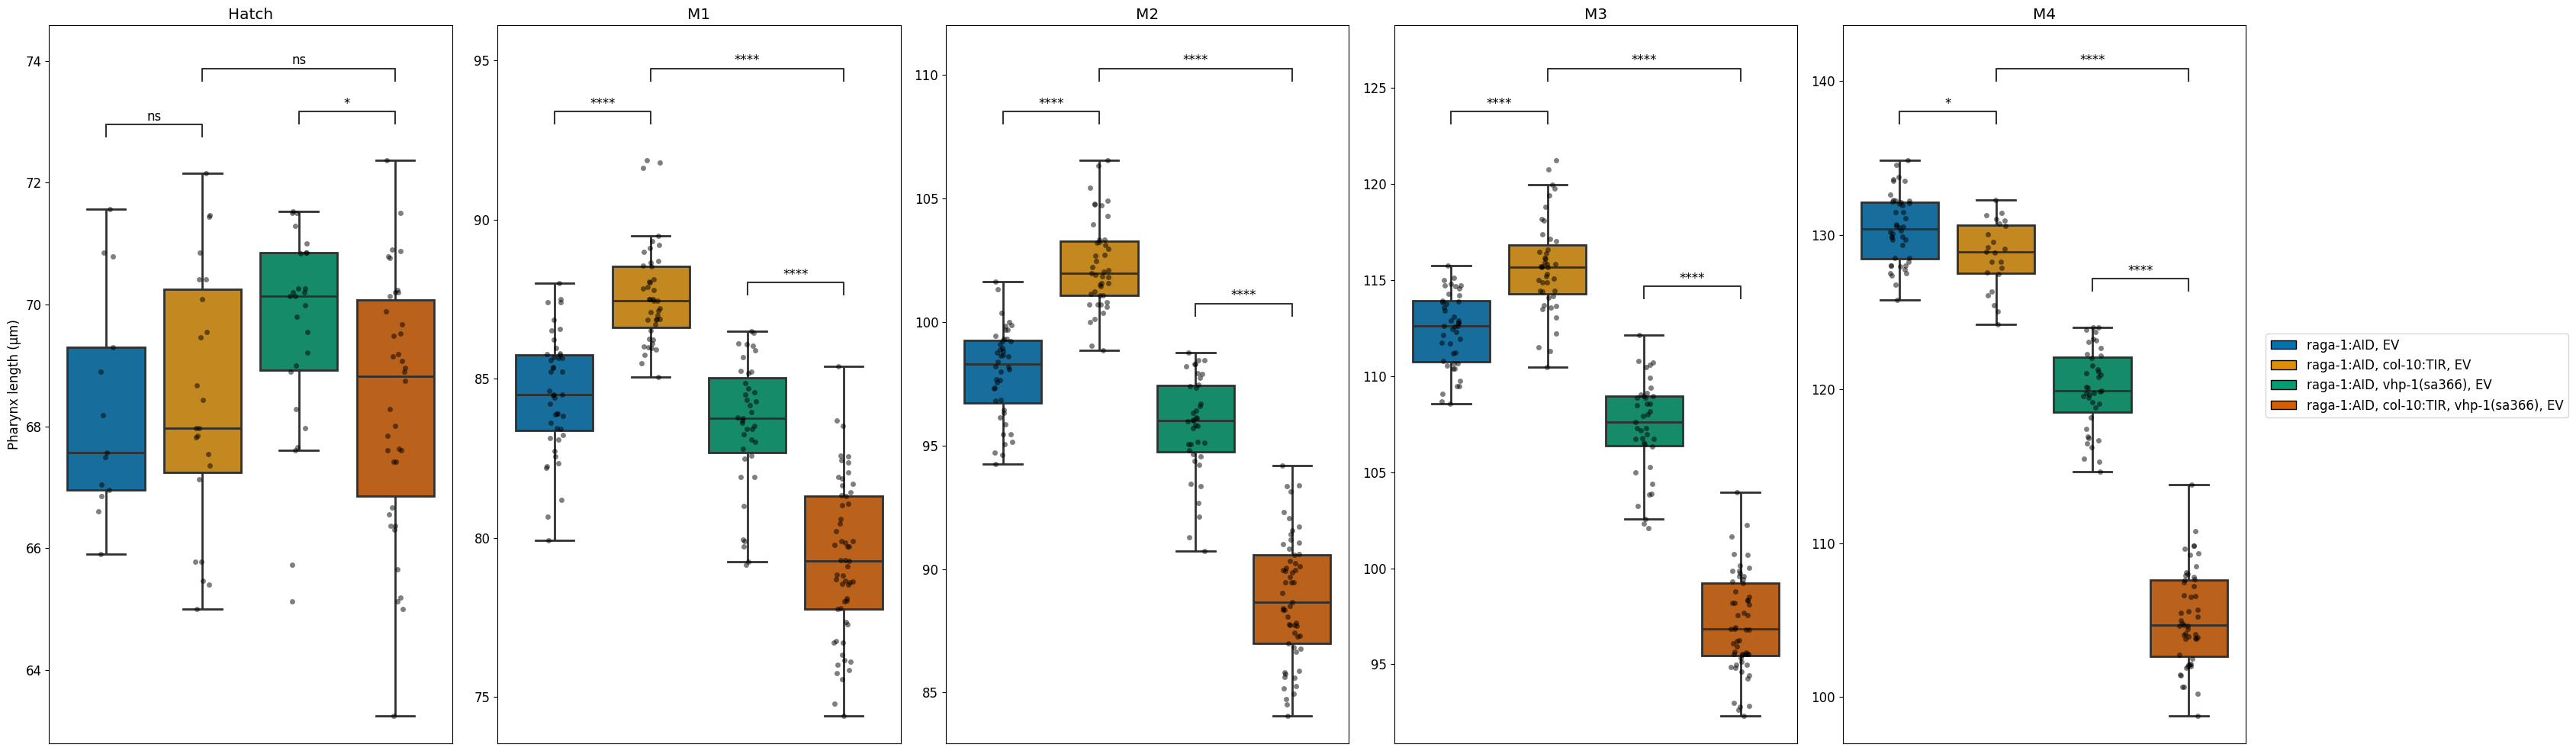

In [16]:
conditions_to_plot = [0, 1, 2, 3]
colors = None
significance_pairs = [(0, 1), (2, 3), (1, 3)]
fig = boxplot_at_molt(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', conditions_to_plot, log_scale = False, plot_significance=True, significance_pairs = significance_pairs, share_y_axis = False, legend = {'description': ''}, y_axis_label="Pharynx length (µm)", titles = ['Hatch', 'M1', 'M2', 'M3', 'M4'])

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:1015: RuntimeWarning: All-NaN slice encountered
  data_of_stage = np.log(data_of_stage) if log_scale else data_of_stage
/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:1135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


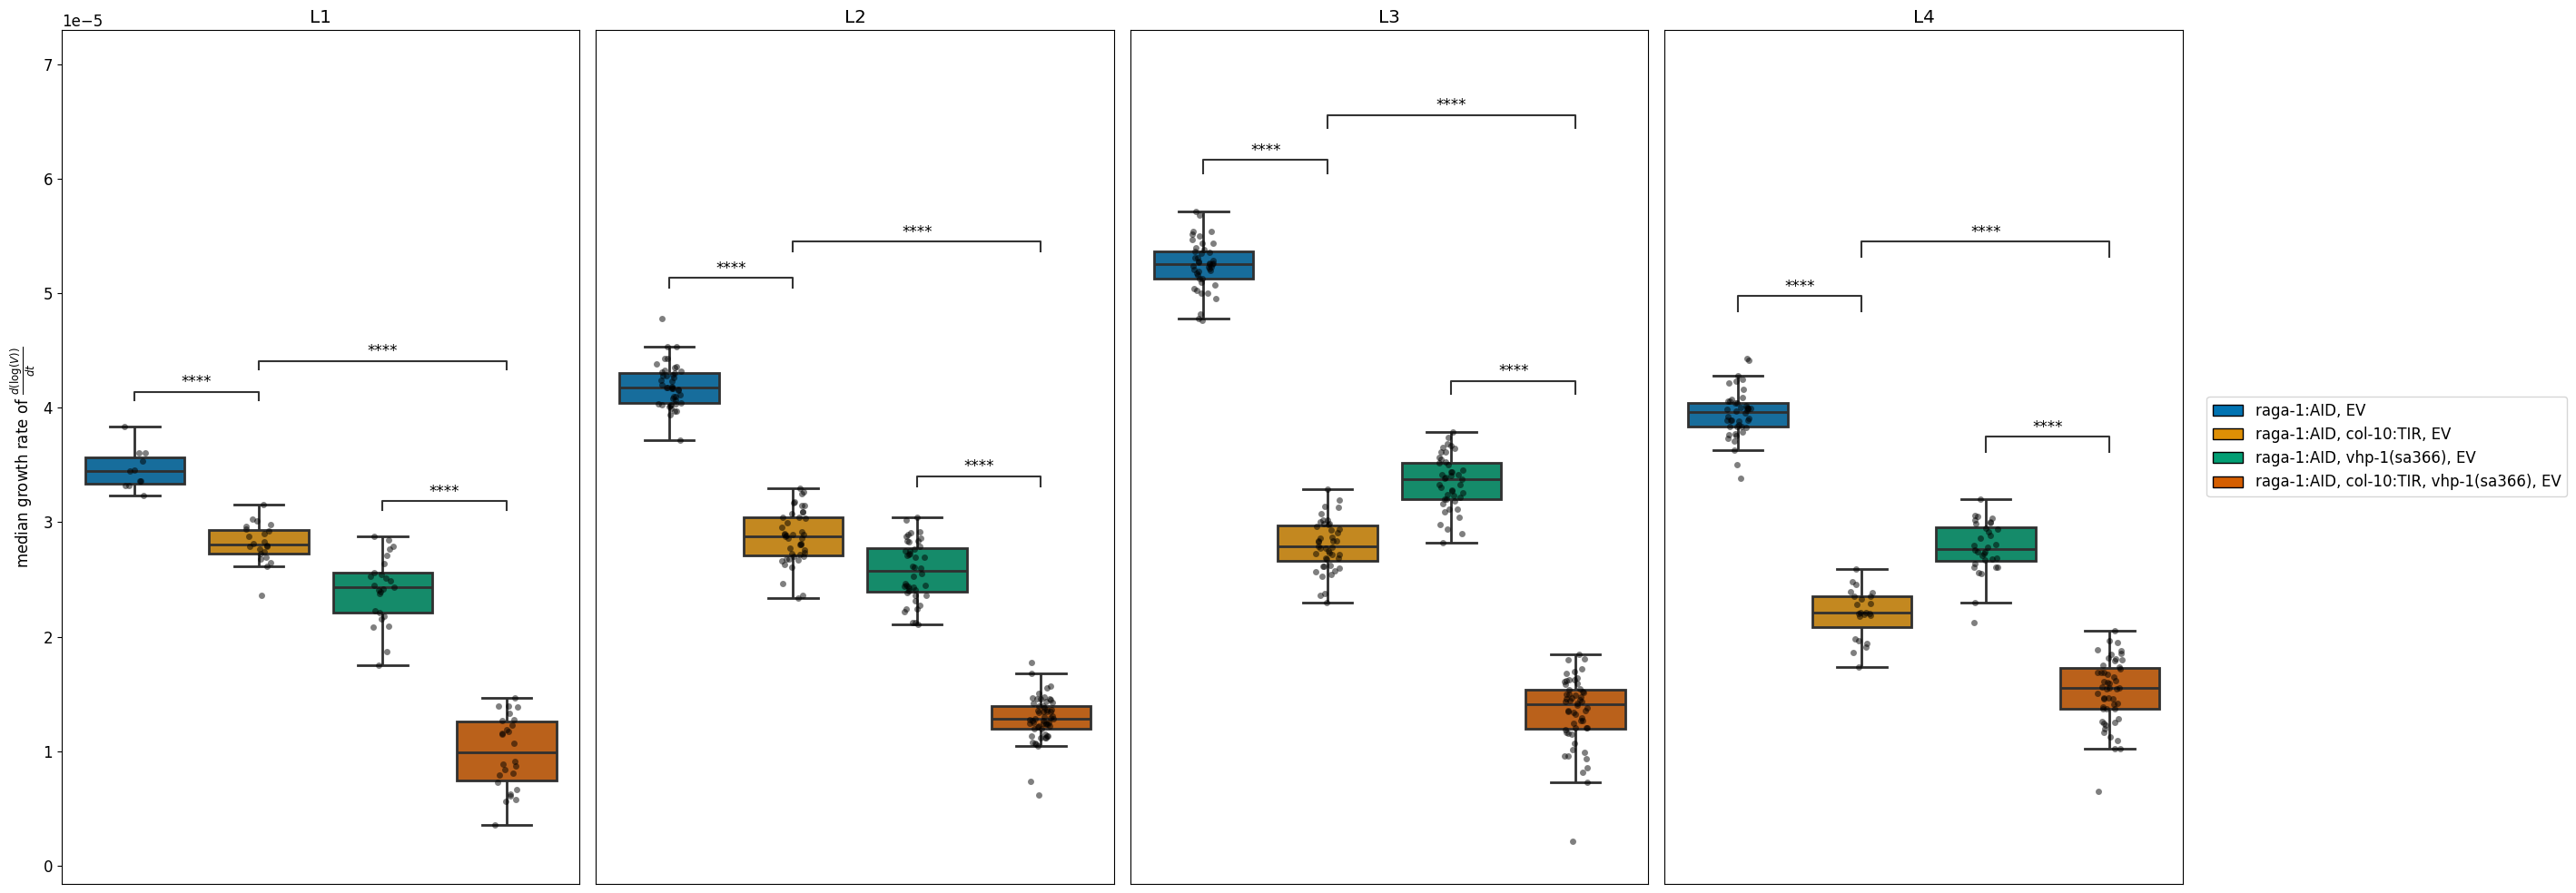

In [17]:
conditions_to_plot = [0, 1, 2, 3]
colors = None
significance_pairs = [(0, 1), (2, 3), (1, 3)]
fig = boxplot_larval_stage(conditions_struct, 'body_seg_str_log_volume_growth_rate', conditions_to_plot, colors=colors, y_axis_label = r"median growth rate of $\frac{d(\log(V))}{dt}$", aggregation='median', plot_significance=True, significance_pairs = significance_pairs, share_y_axis = True, n_points=100, fraction=0.8, log_scale=False, titles = ['L1', 'L2', 'L3', 'L4'], legend={'description': ''})

<>:2: DeprecationWarning: invalid escape sequence \m


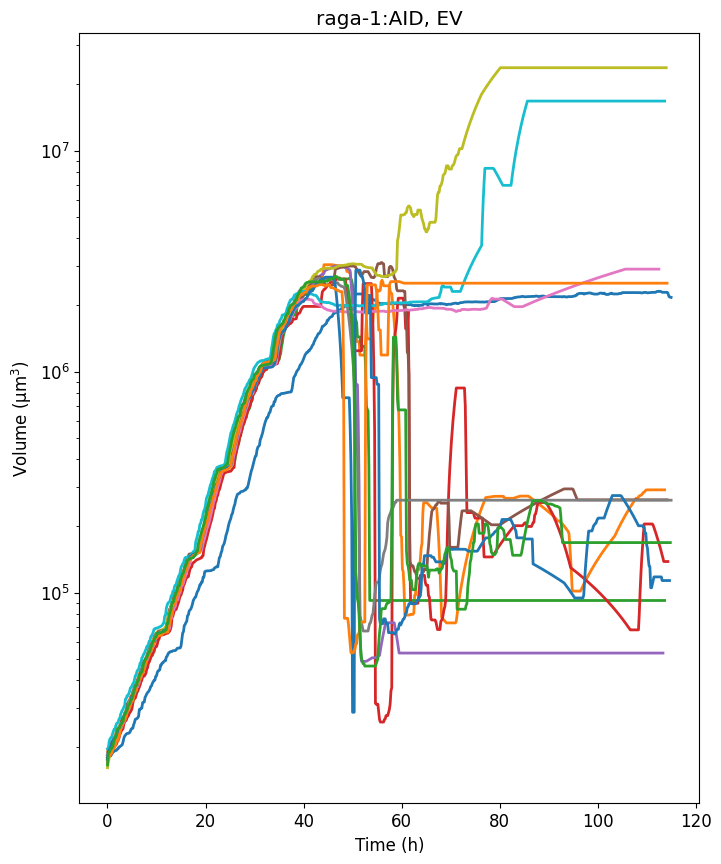

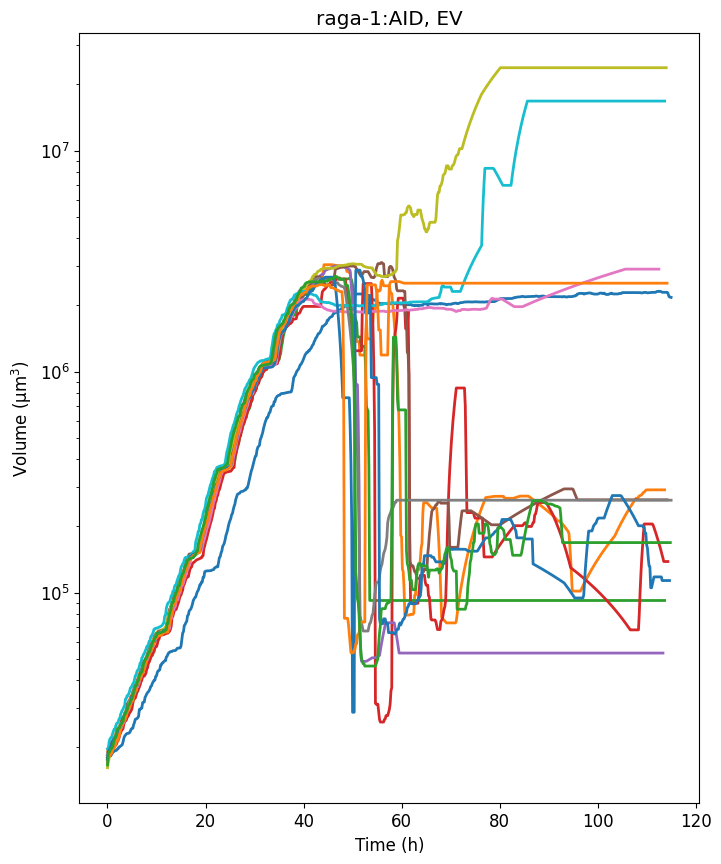

In [25]:
conditions_to_plot = [0]
plot_growth_curves_individuals(conditions_struct, 'body_seg_str_volume', conditions_to_plot, log_scale = True, legend = {'description': None}, y_axis_label = 'Volume ($\mathrm{\mu m^3}$)')

## yap-1 loss makes worms dumpy

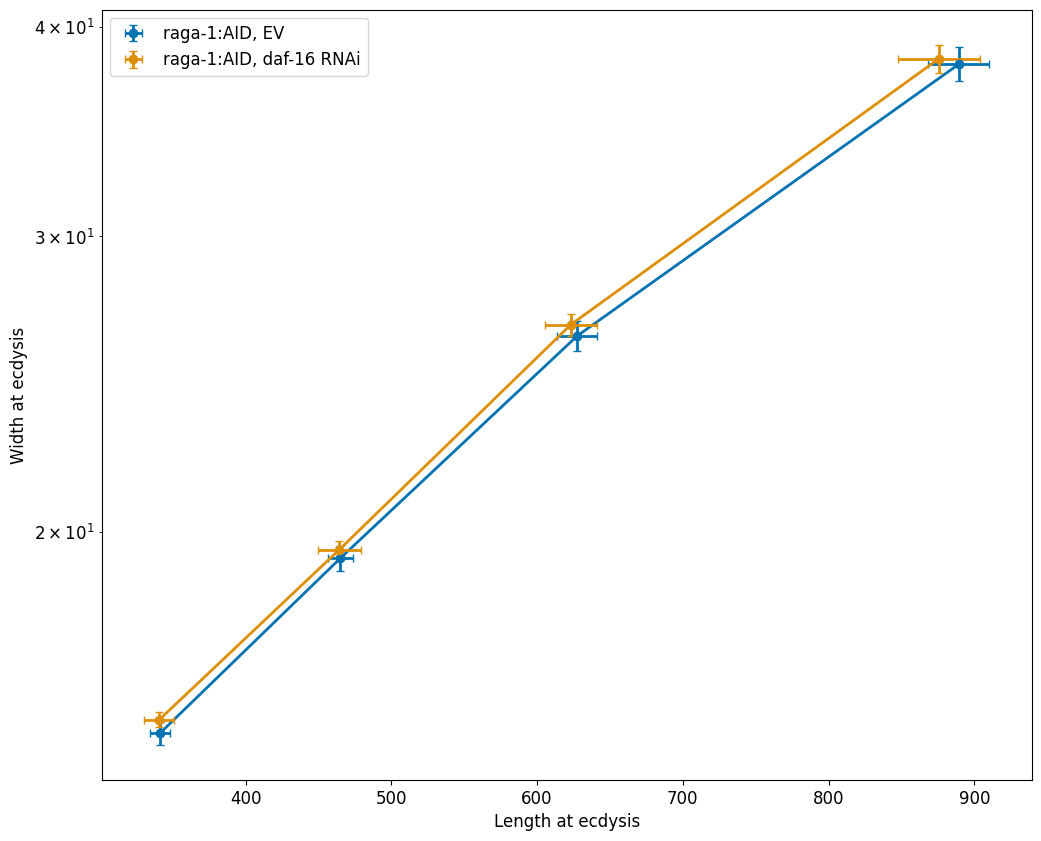

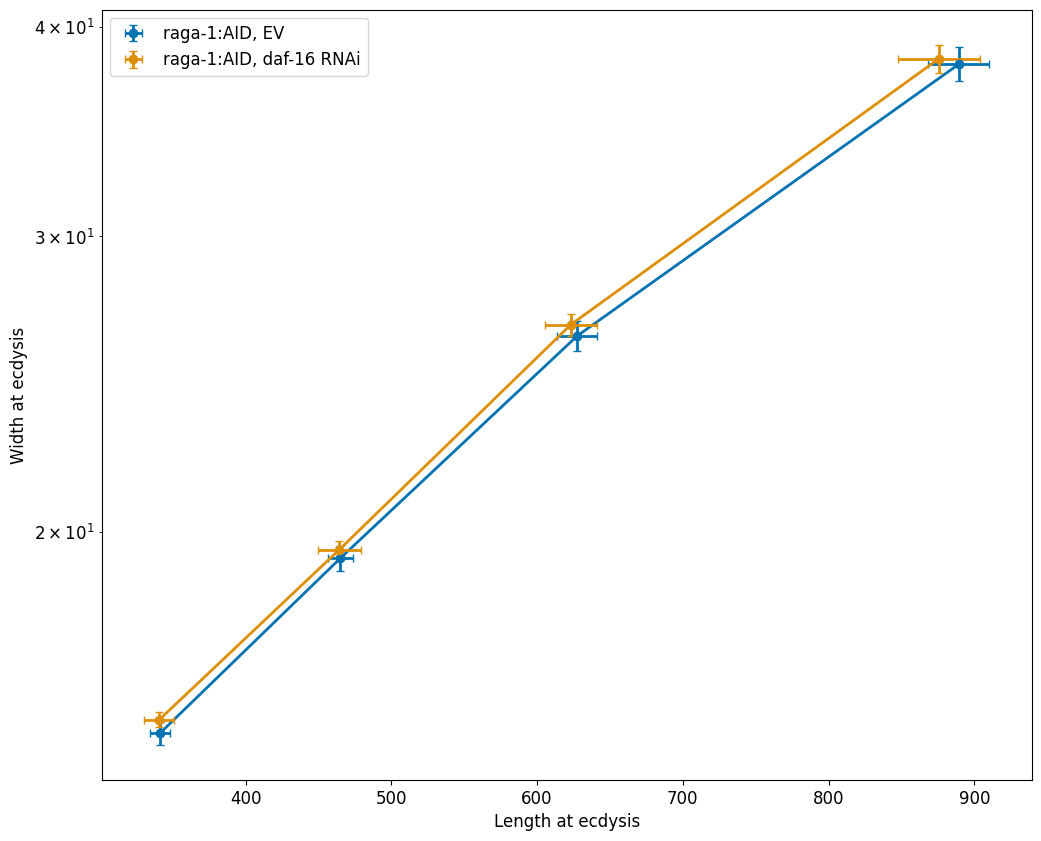

In [26]:
conditions_to_plot = [0, 4]
colors = None

plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Width at ecdysis', x_axis_label='Length at ecdysis')

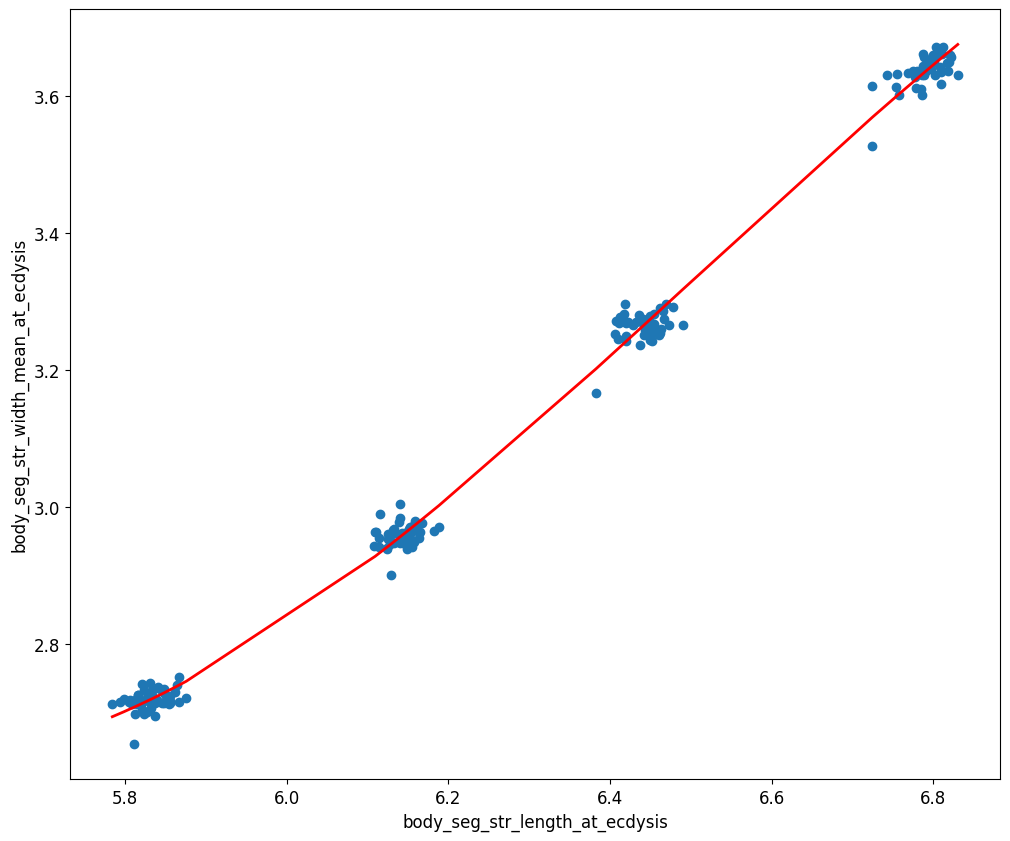

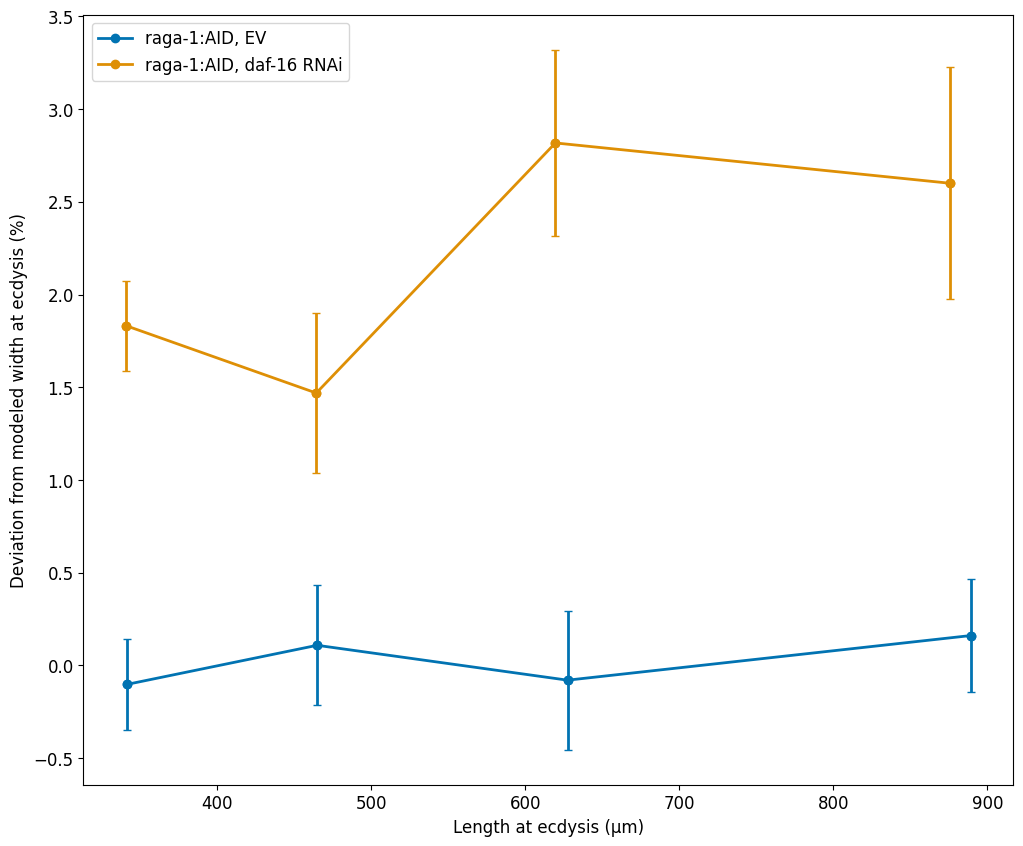

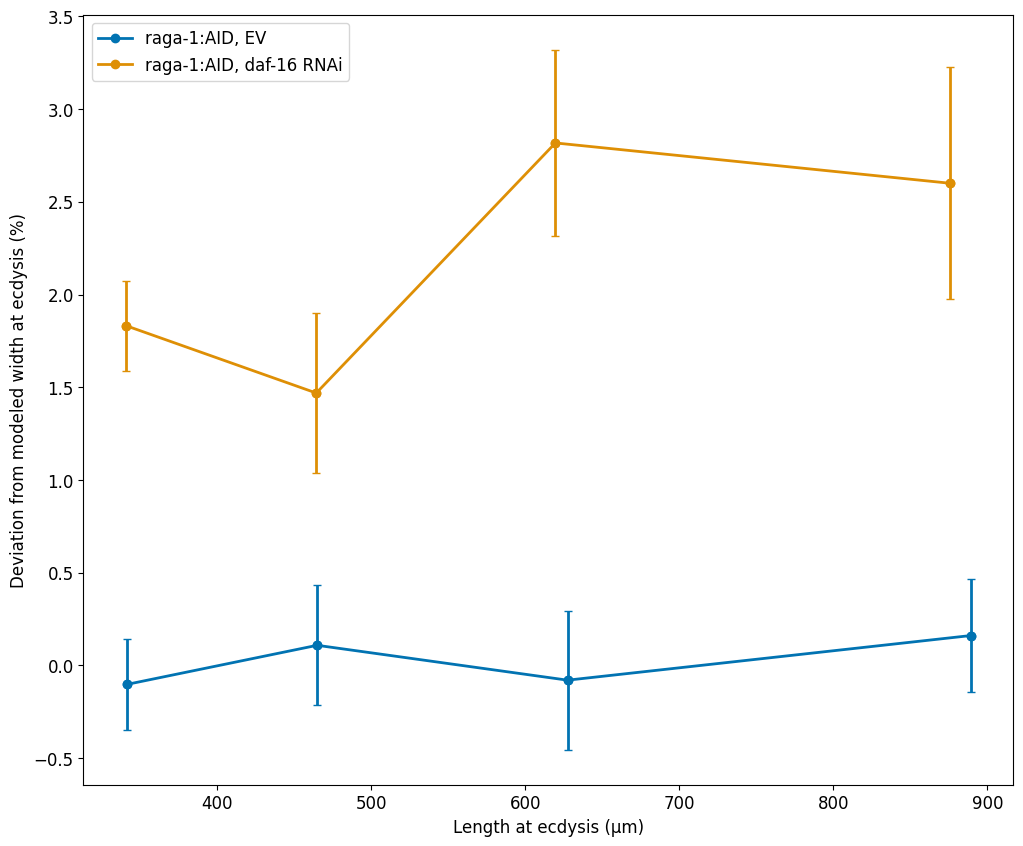

In [27]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_width_mean_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled width at ecdysis (%)')

## yap-1 loss leads to width irregularities

/home/spsalmon/towbintools_pipeline/analysis_and_plots/plotting_functions.py:987: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


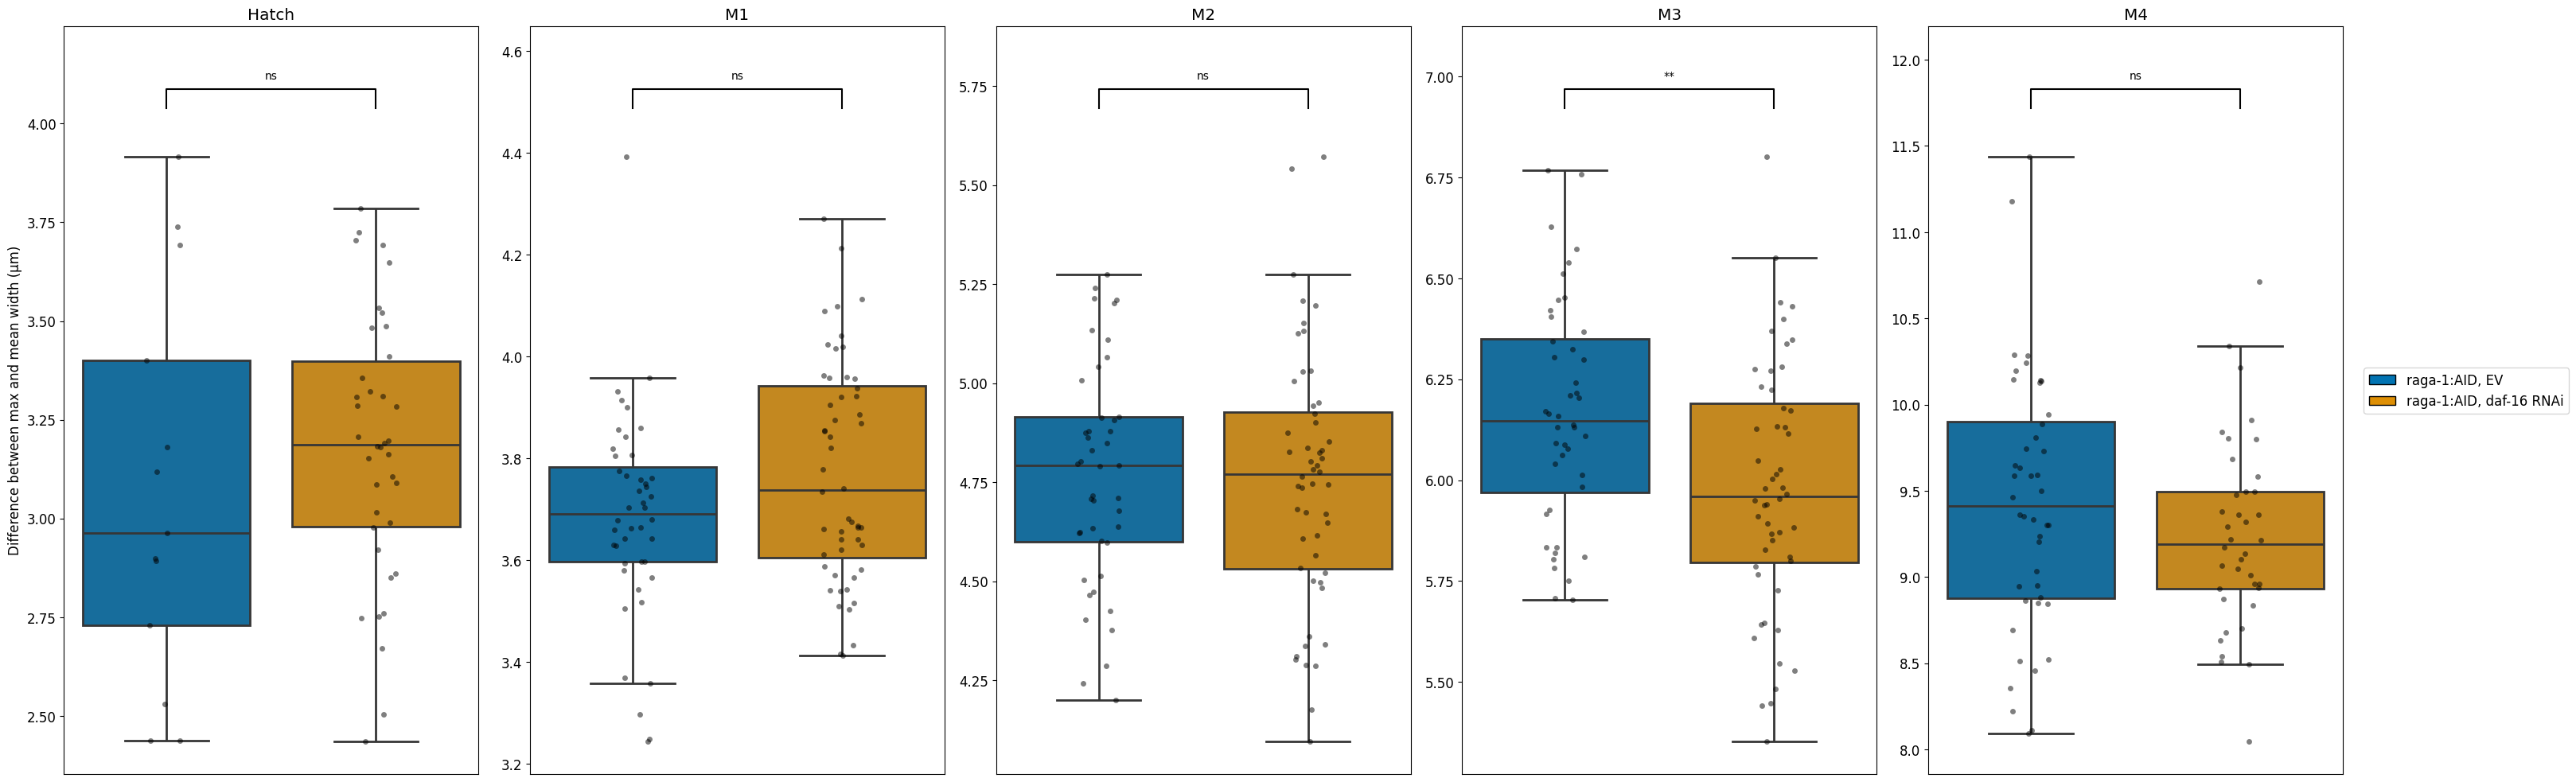

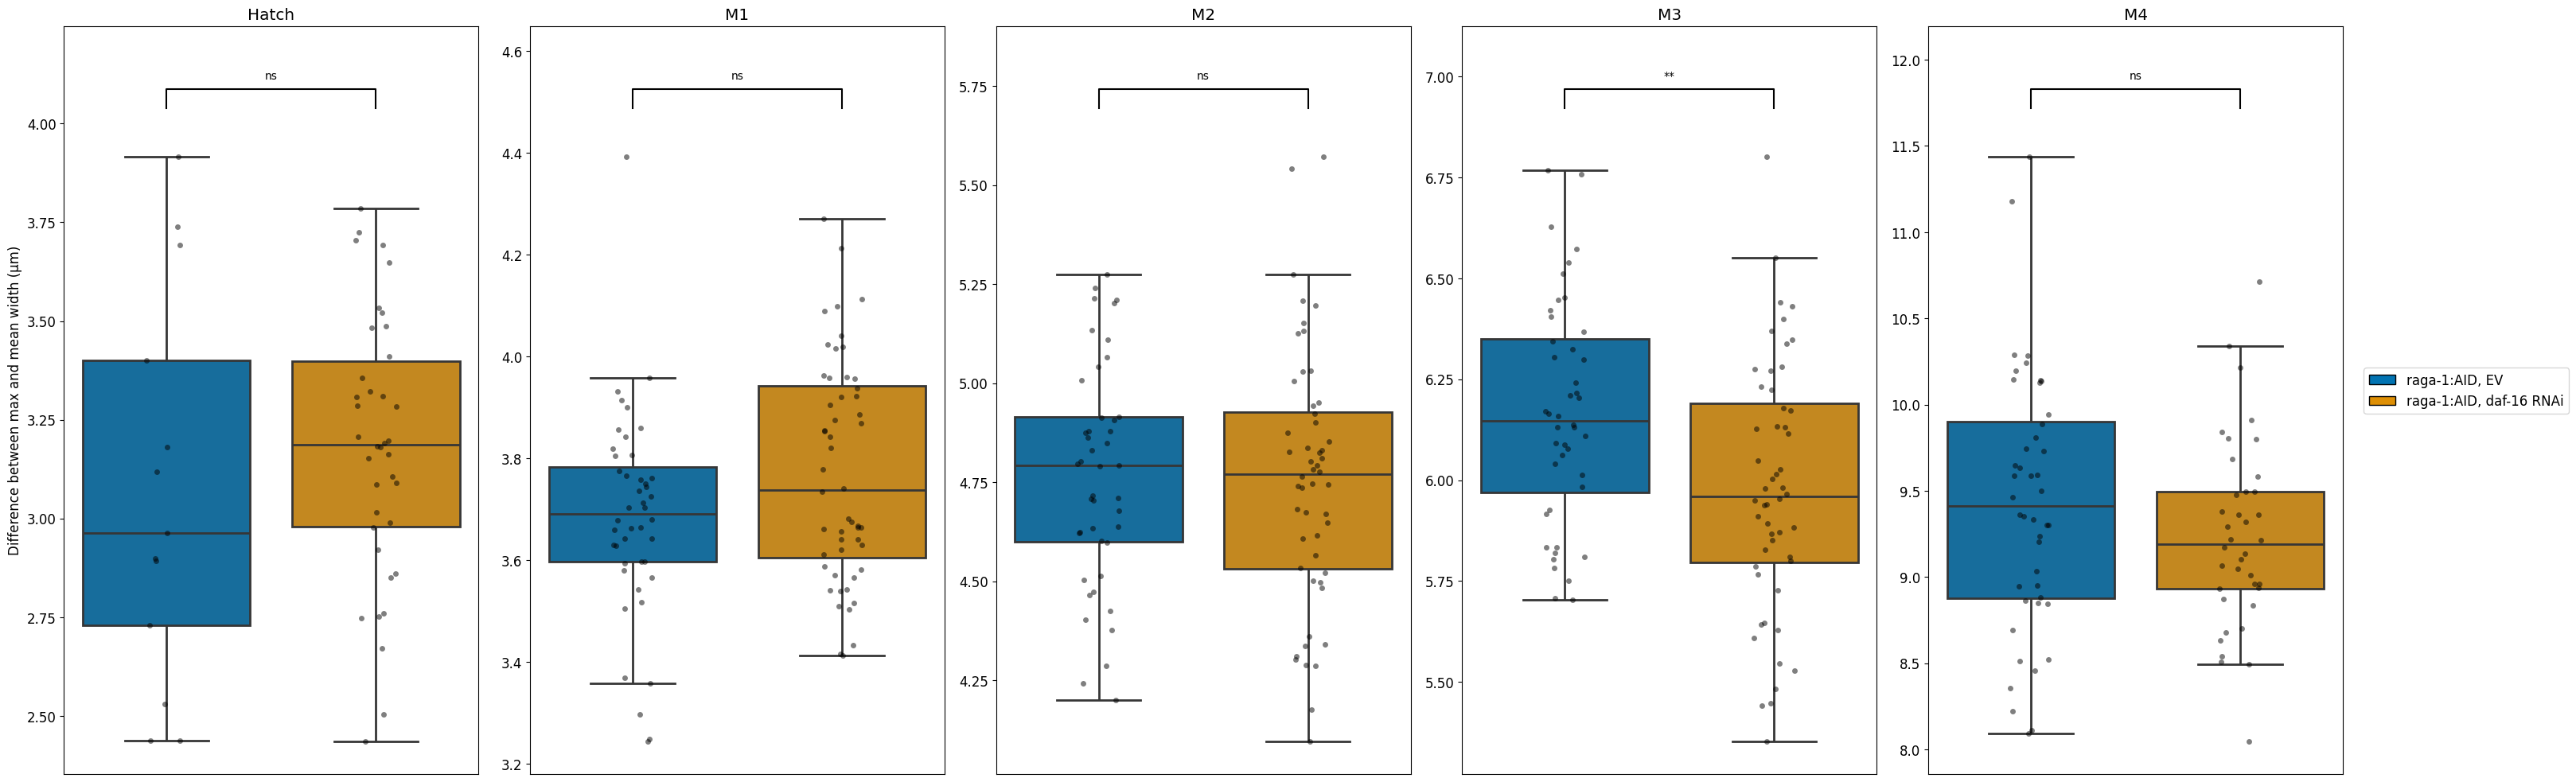

In [30]:
boxplot_at_molt(conditions_struct, 'body_seg_str_width_max_minus_mean_at_ecdysis', [0, 4], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Difference between max and mean width (µm)", titles = ['Hatch', 'M1', 'M2', 'M3', 'M4'])

## yap-1 deletion makes body shape more heterogenious

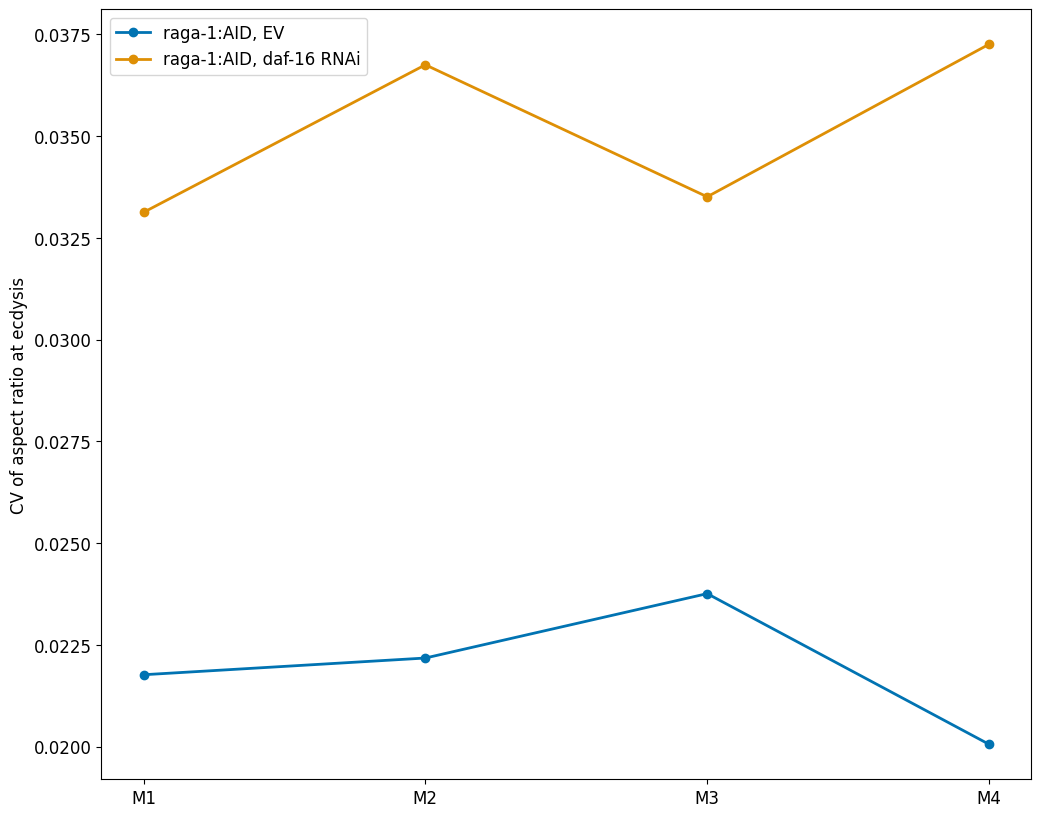

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of aspect ratio at ecdysis')   

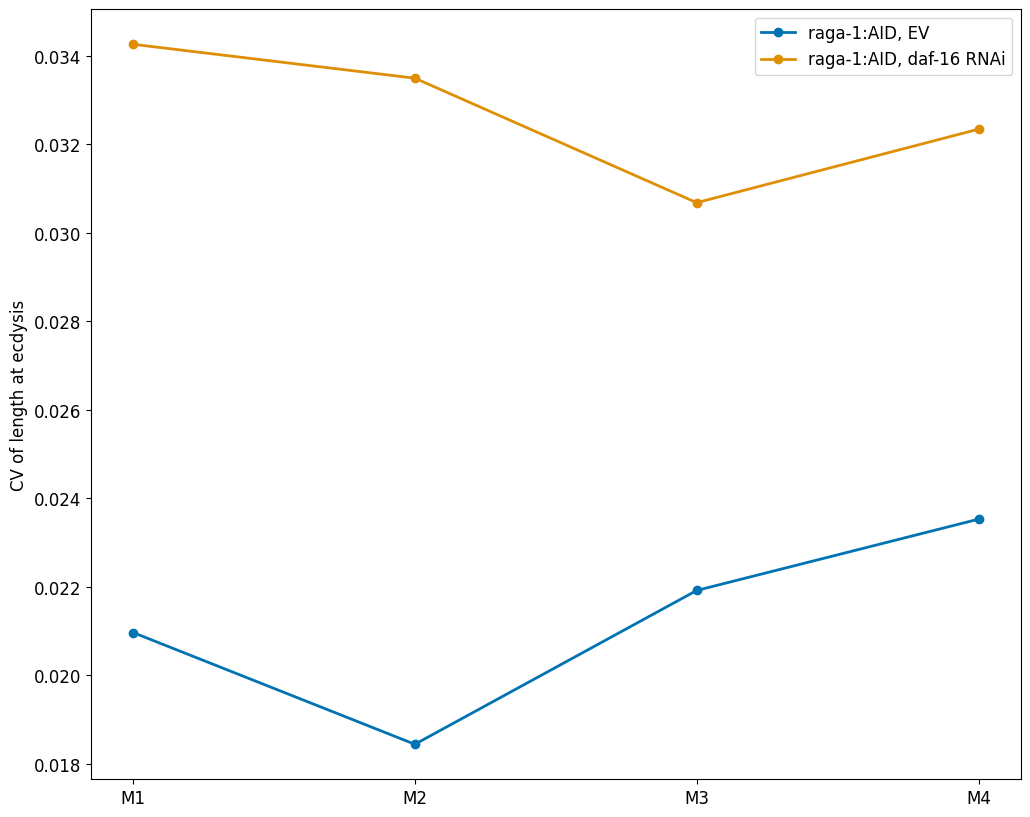

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length at ecdysis')   

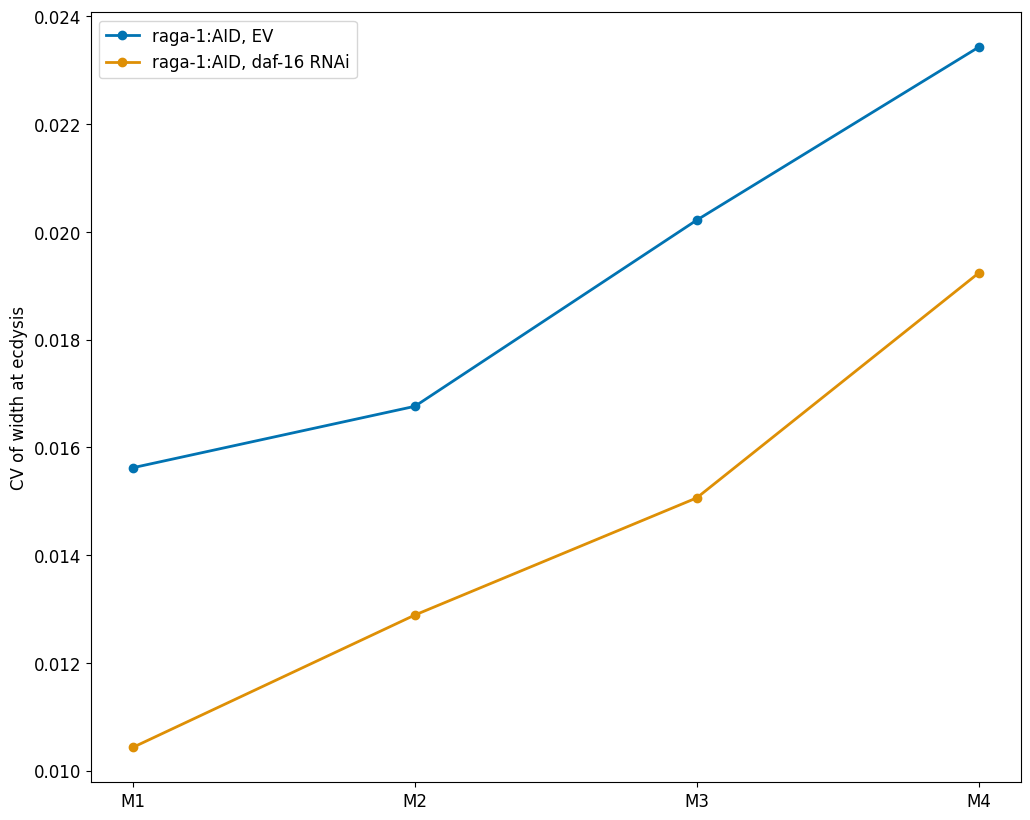

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width at ecdysis')   

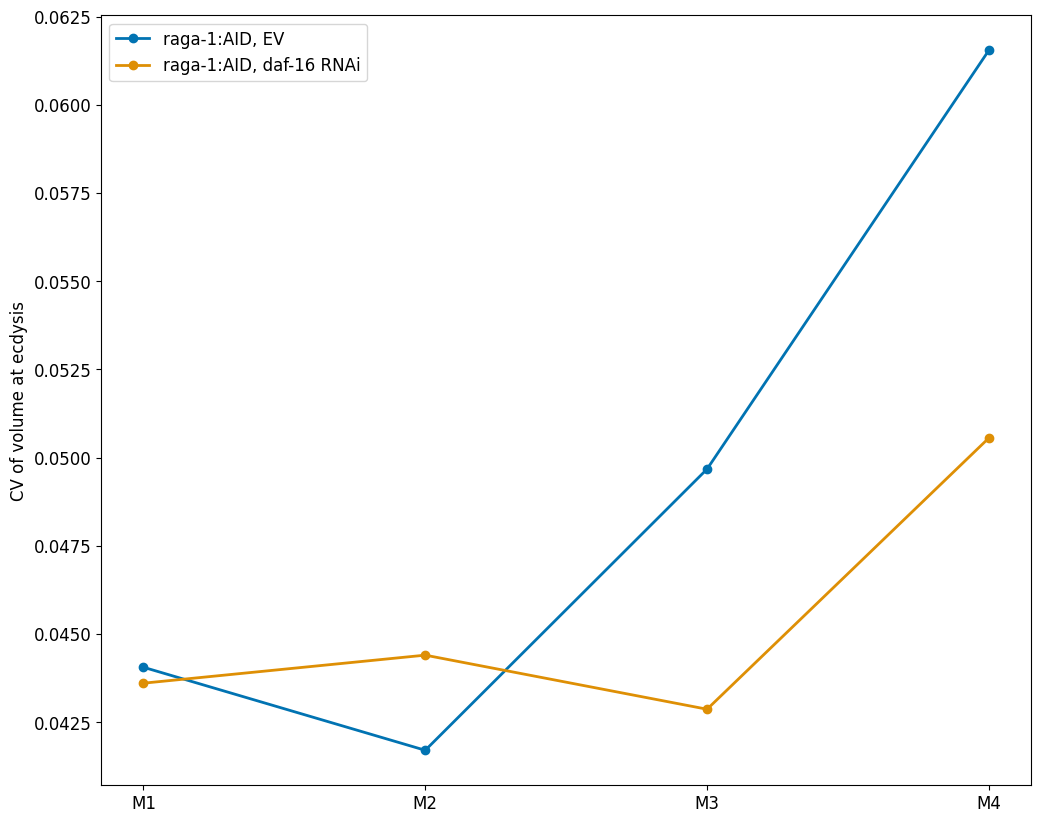

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume at ecdysis')   

## yap-1 loss doesn’t affect pharynx/body volume proportions

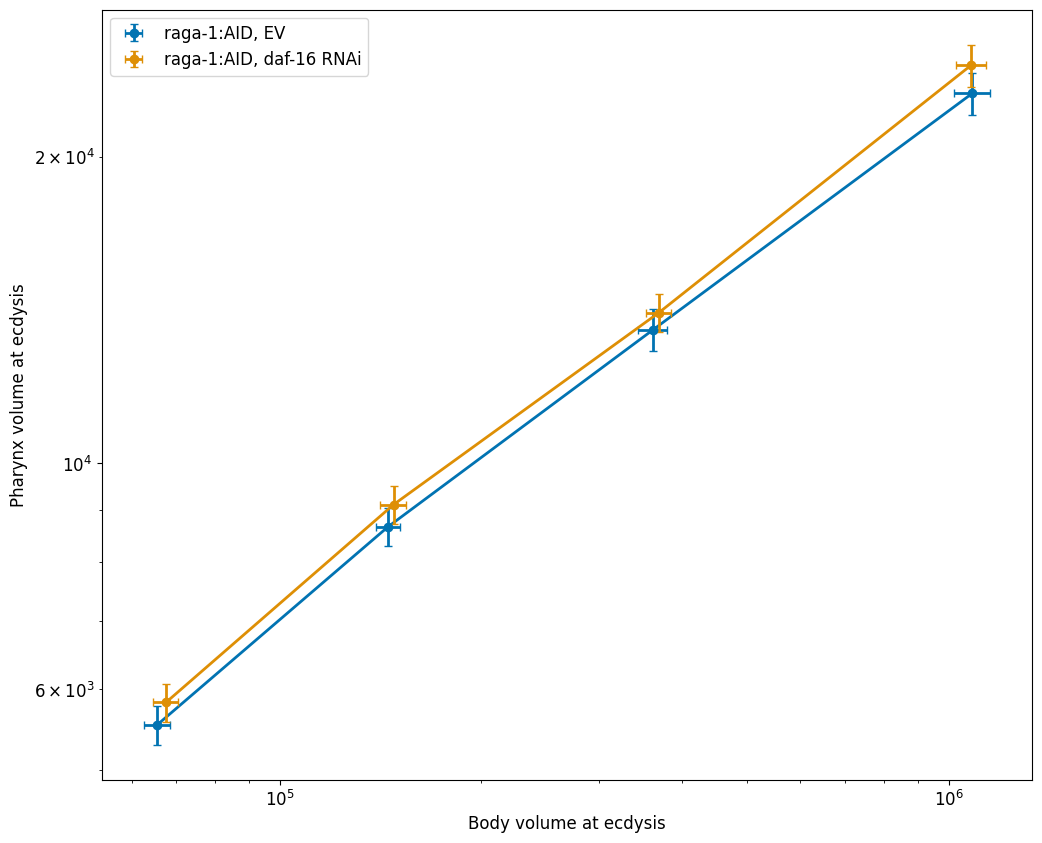

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body volume at ecdysis', y_axis_label='Pharynx volume at ecdysis')

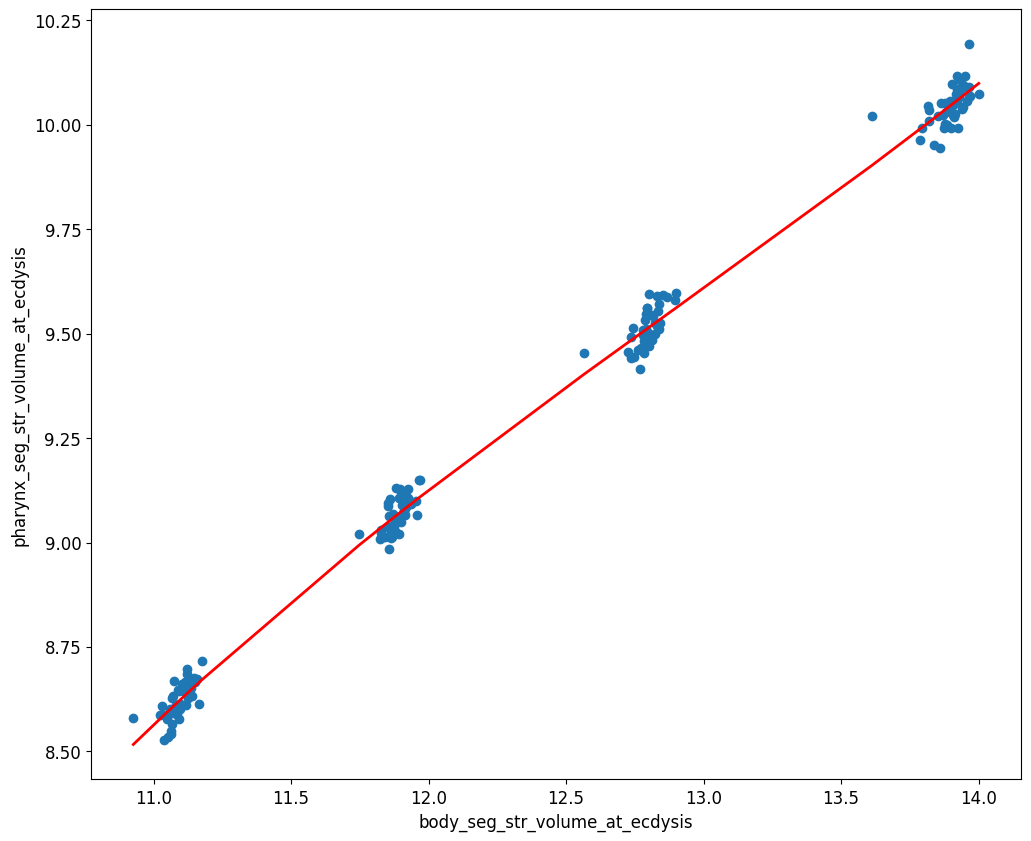

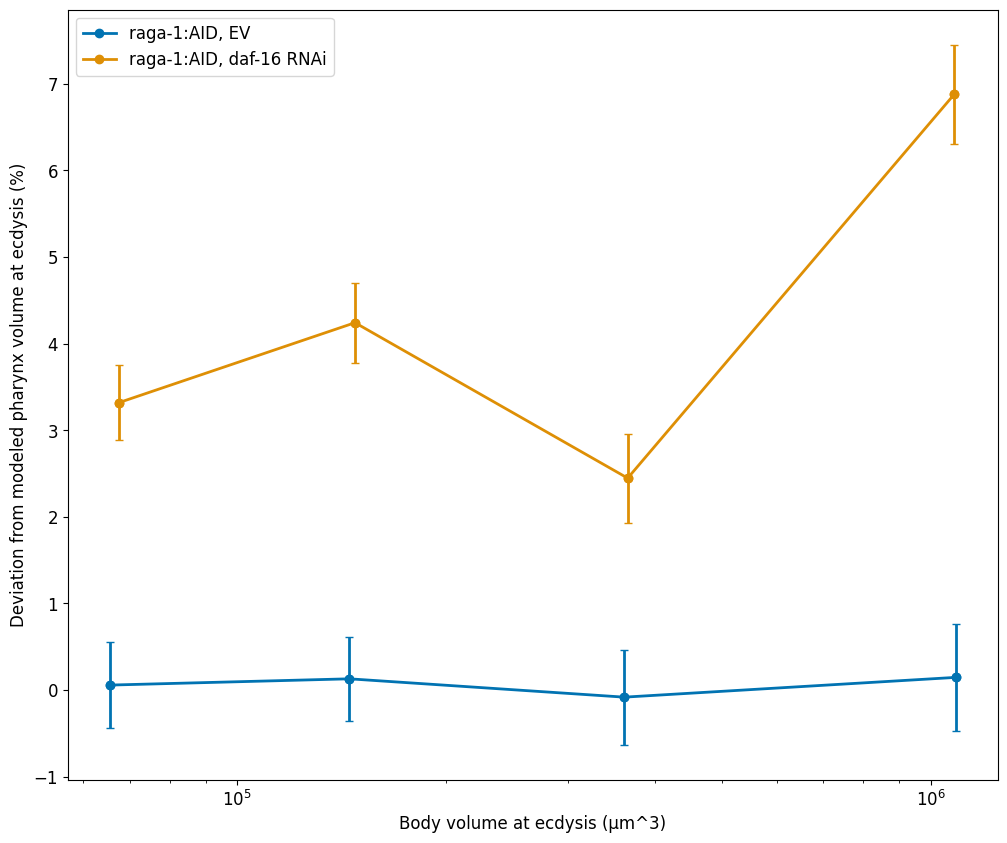

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume at ecdysis (µm^3)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

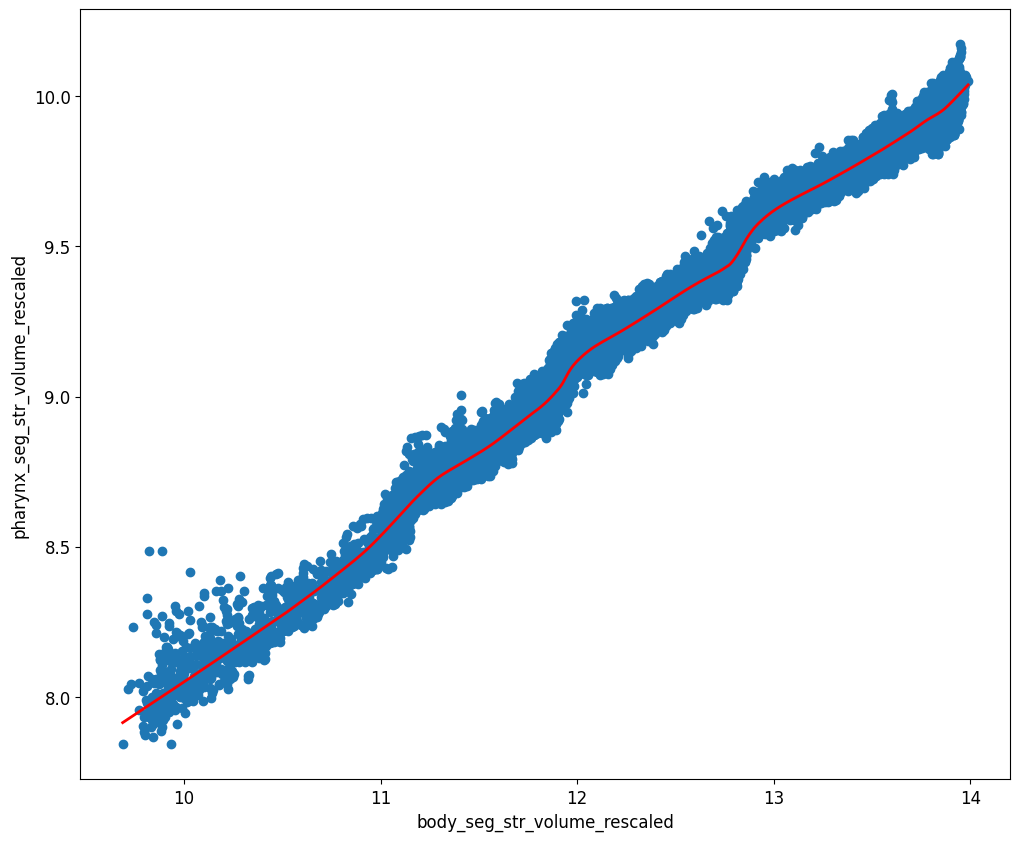

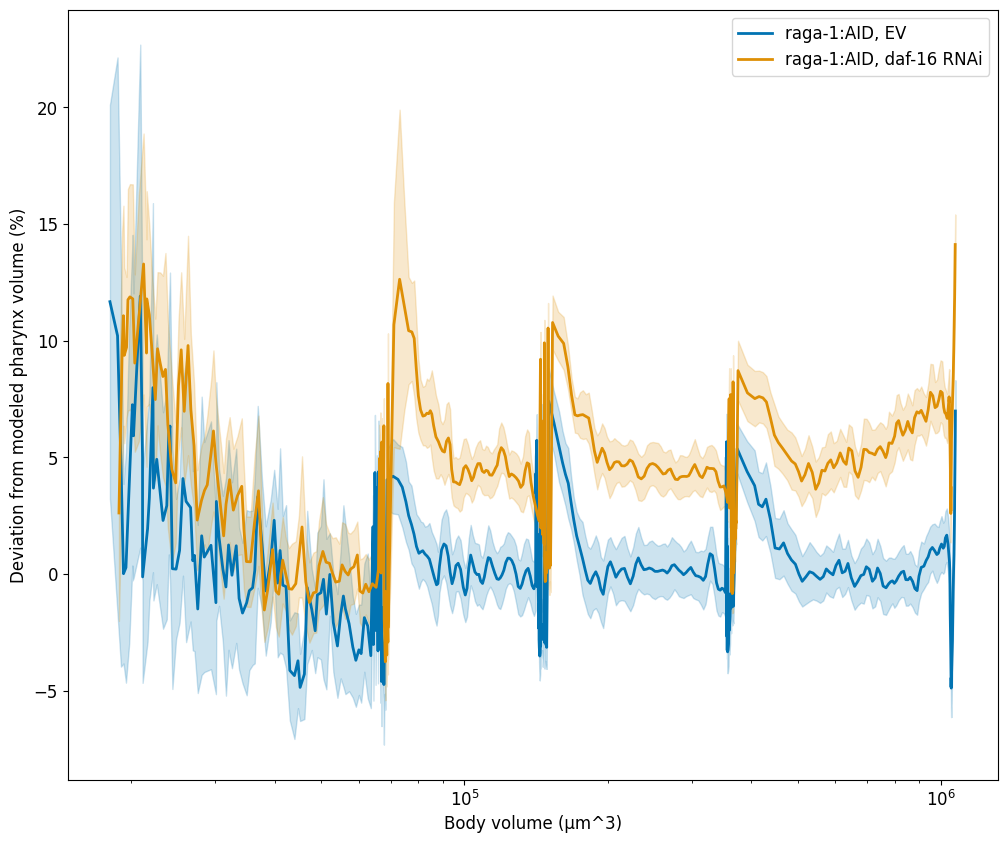

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0

plot_deviation_from_model(conditions_struct, "body_seg_str_volume_rescaled", "pharynx_seg_str_volume_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume (µm^3)', y_axis_label='Deviation from modeled pharynx volume (%)')

## yap-1 loss makes pharynxes too short for their respective body length

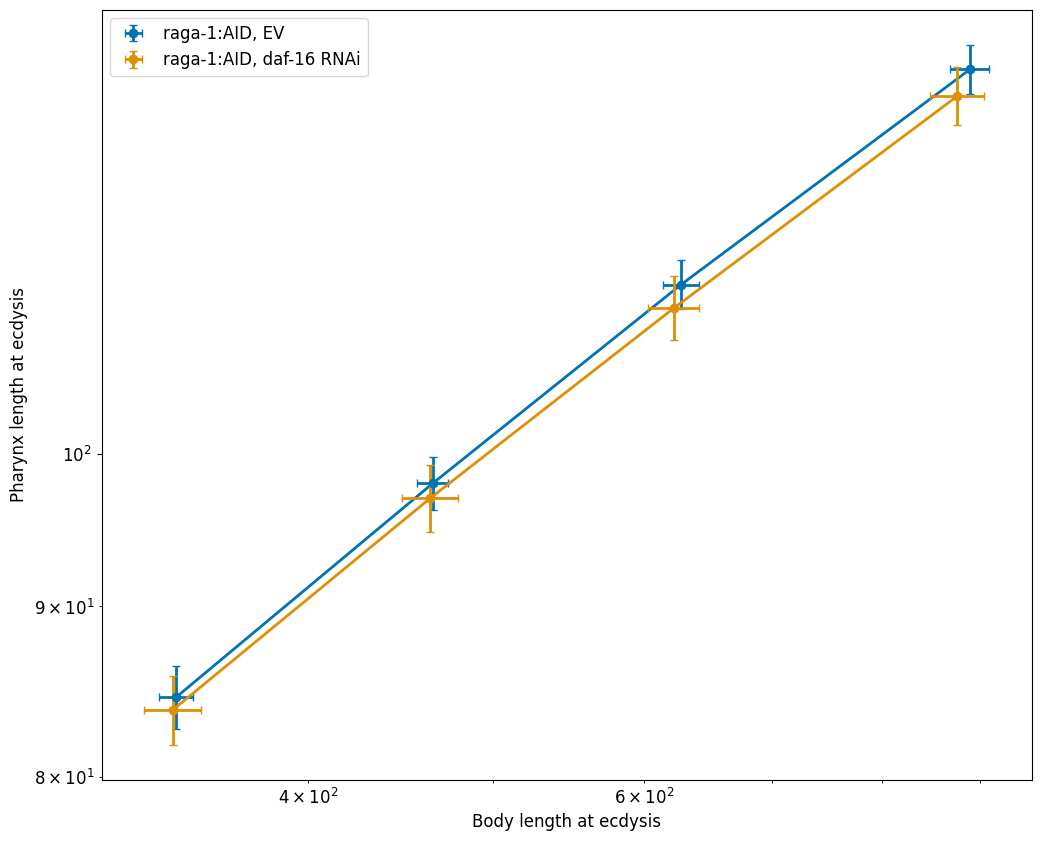

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body length at ecdysis', y_axis_label='Pharynx length at ecdysis')

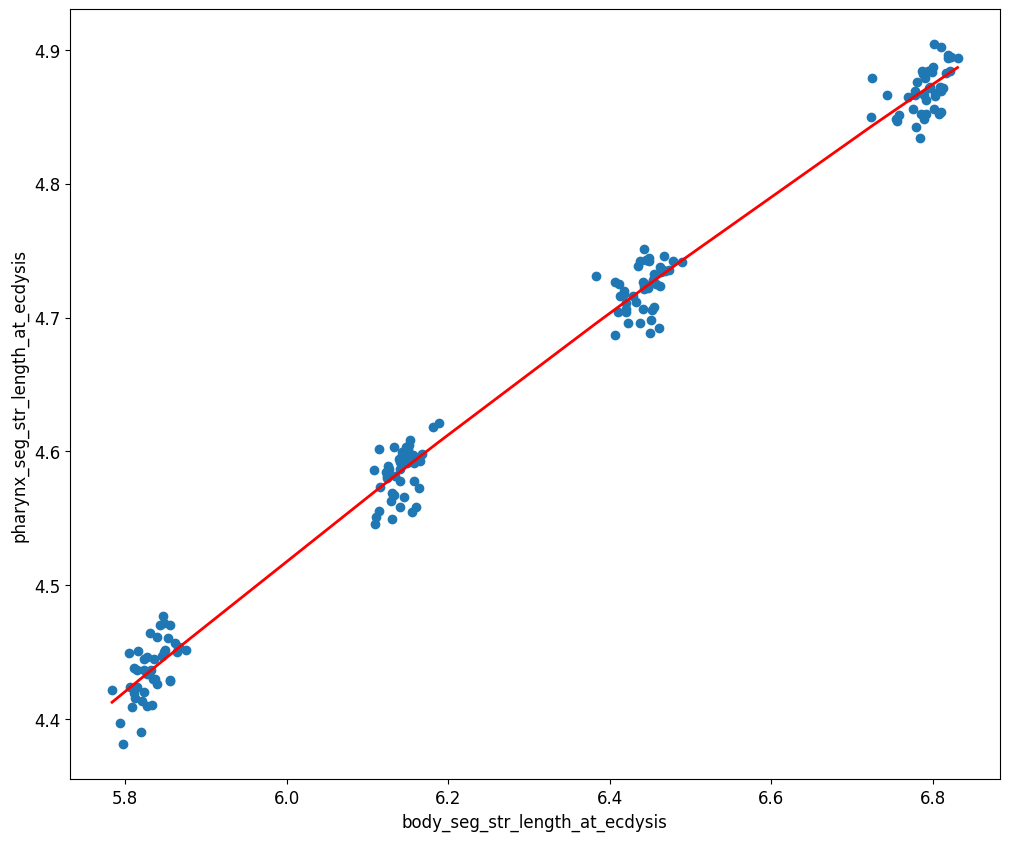

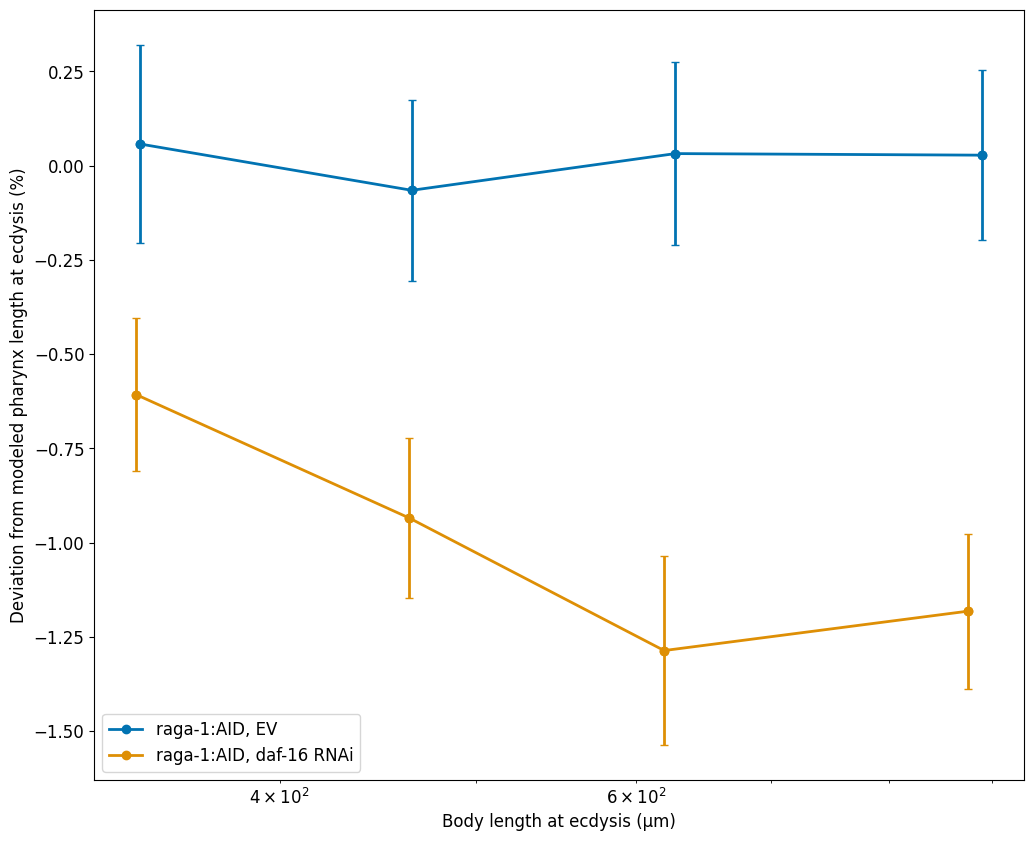

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx length at ecdysis (%)')

## yap-1 loss makes pharynxes dumpy

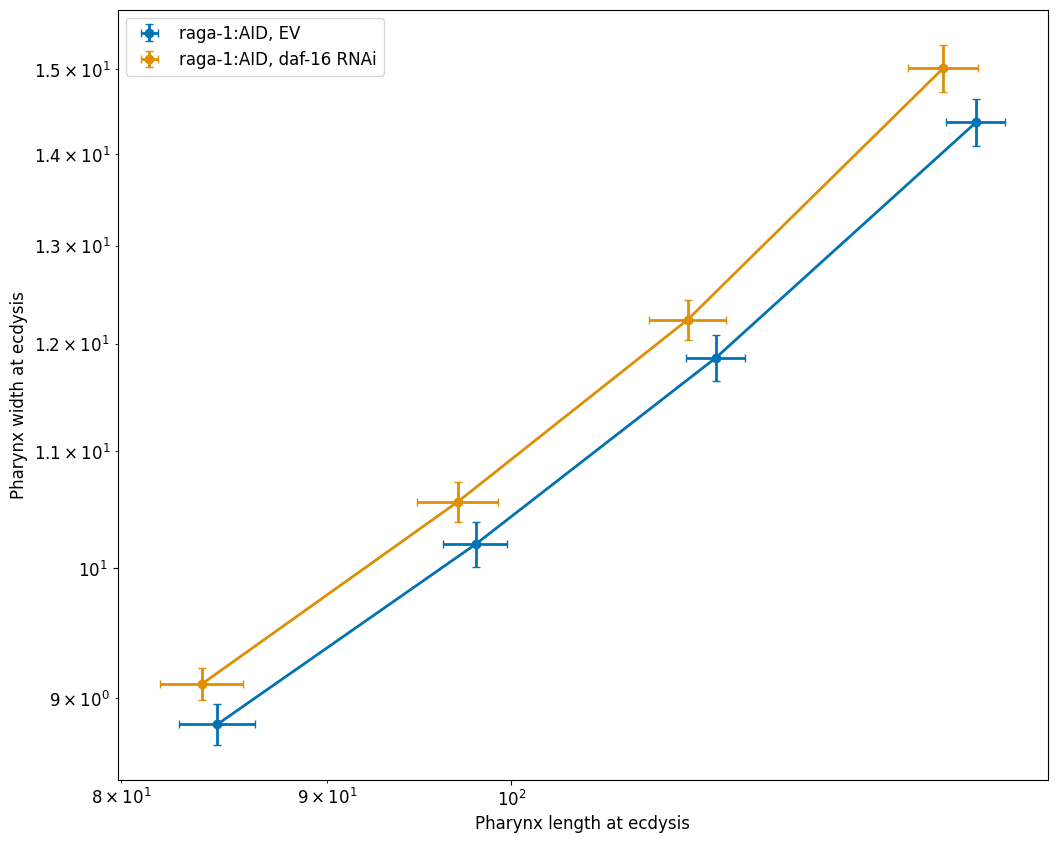

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis', y_axis_label='Pharynx width at ecdysis')

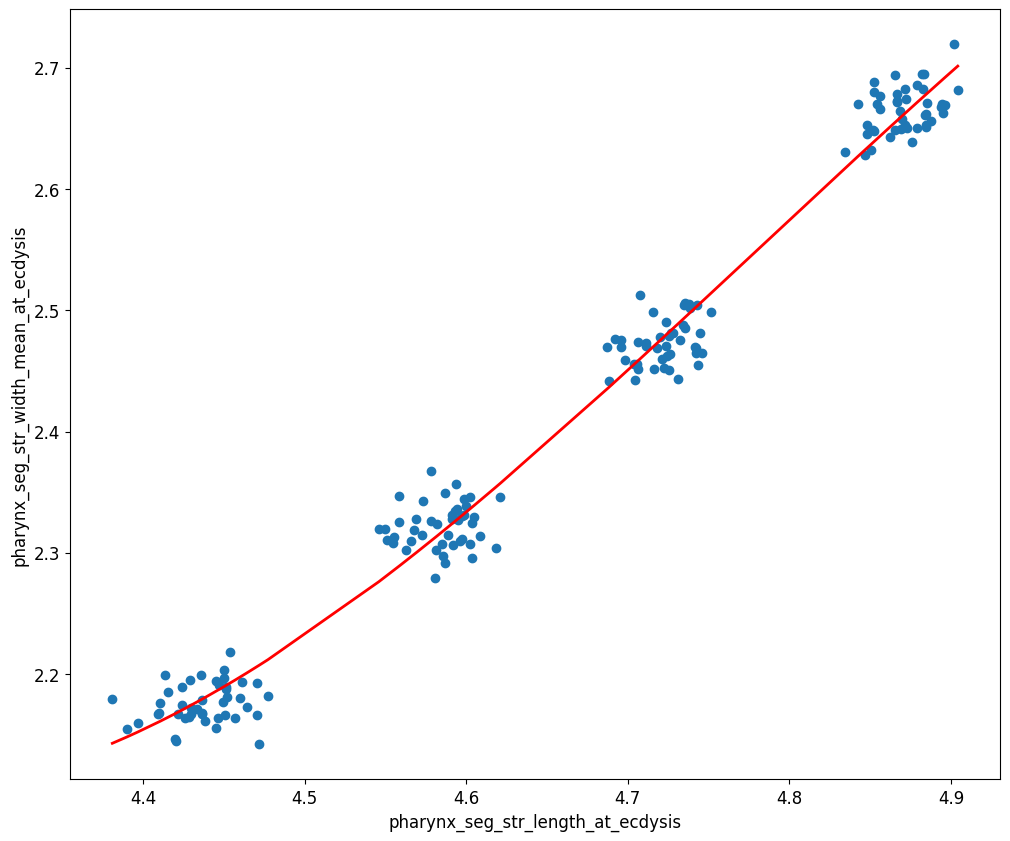

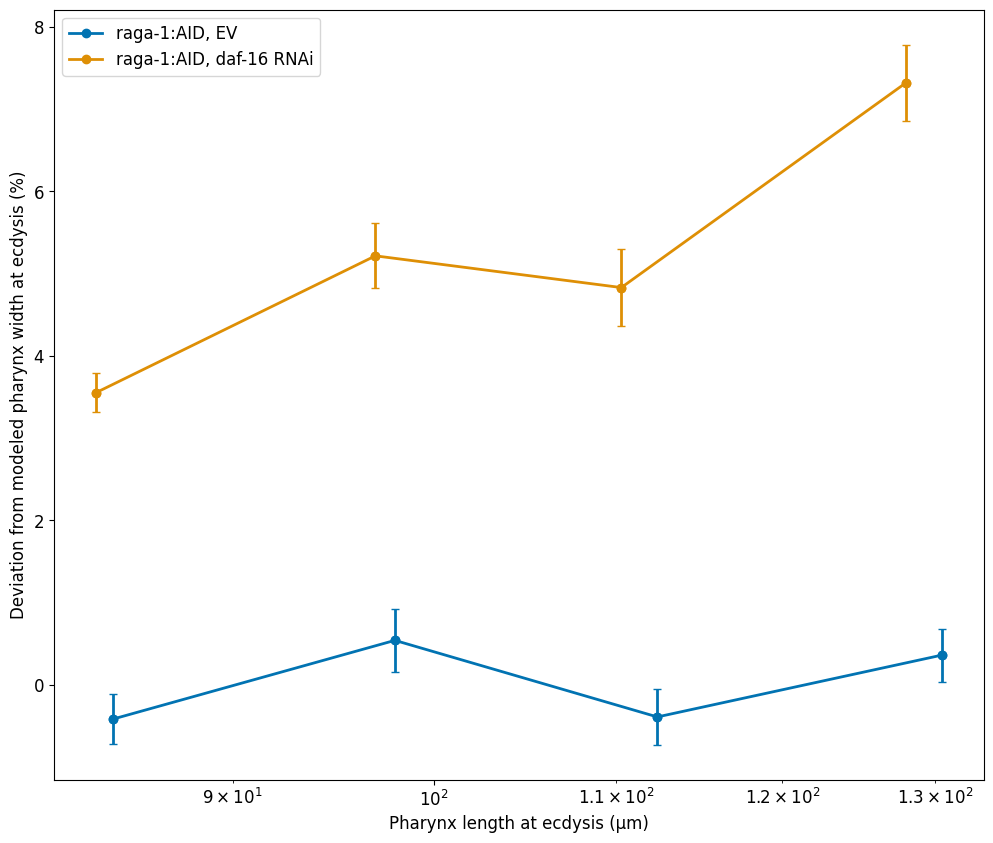

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx width at ecdysis (%)')

## Contour plots

In [ ]:
paths = get_most_average_size_at_ecdysis(
    conditions_struct,
    'pharynx_seg_str_volume_at_ecdysis',
    ['analysis/ch1_seg_str'],
    [0, 1],
    remove_hatch=False,
    exclude_arrests=True,
    nb_per_condition=2,
)

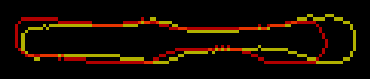

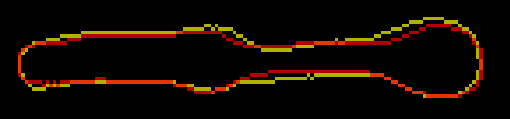

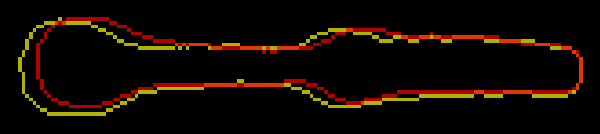

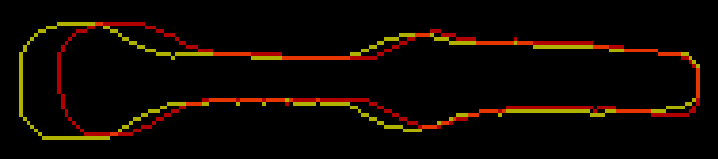

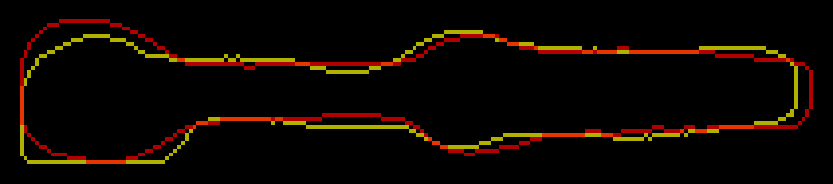

In [ ]:
contour_condition_1 = paths[1][0][0]
contour_condition_0 = paths[0][0][0]
overlay_contours(contour_condition_1[0], contour_condition_0[0], dpi=1, scale=5.0, allign='left', thickness=1)

contour_condition_1 = paths[1][1][0]
contour_condition_0 = paths[0][1][0]
overlay_contours(contour_condition_1[0], contour_condition_0[0], dpi=1, scale=5.0, allign='left', thickness=1)

contour_condition_1 = paths[1][2][0]
contour_condition_0 = paths[0][2][0]
overlay_contours(contour_condition_1[0], contour_condition_0[0], dpi=1, scale=5.0, allign='right', thickness=1)

contour_condition_1 = paths[1][3][0]
contour_condition_0 = paths[0][3][0]
overlay_contours(contour_condition_1[0], contour_condition_0[0], dpi=1, scale=5.0, allign='right', thickness=1)

contour_condition_1 = paths[1][4][0]
contour_condition_0 = paths[0][4][0]
overlay_contours(contour_condition_1[0], contour_condition_0[0], dpi=1, scale=5.0, allign='left', thickness=1)